In [ ]:
!pip install tensorflow==2.7.0

     |████████████████████████████████| 489.6 MB 18 kB/s 
     |████████████████████████████████| 463 kB 56.8 MB/s 
     |████████████████████████████████| 1.3 MB 43.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


In [ ]:
!pip install tensorflow_quantum

     |████████████████████████████████| 10.5 MB 5.2 MB/s 
     |████████████████████████████████| 90 kB 8.6 MB/s 
     |████████████████████████████████| 100 kB 8.7 MB/s 
     |████████████████████████████████| 437 kB 54.6 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 6.1 MB 27.1 MB/s 
     |████████████████████████████████| 1.6 MB 44.6 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 93 kB 980 kB/s 
     |████████████████████████████████| 93 kB 804 kB/s 
     |████████████████████████████████| 92 kB 1.1 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████|

In [ ]:
!pip install gym==0.18.0

     |████████████████████████████████| 1.6 MB 5.0 MB/s 
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656449 sha256=fb5b7ab64b1863d1aee9fcc8582fd5878ad14a019b3b2adf0430a1e374ea6c3f
  Stored in directory: /root/.cache/pip/wheels/99/f7/e3/d6f0f120ac047c1e5de2ae34930e7bf6e8de1c7a4d5fa68555
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy

number_of_reuse = 8
class PPO_agent(object):
    def __init__(self, action_space, state_space) -> None:
        super().__init__()
        self.action_space = action_space
        self.state_space = state_space[0]
        self.e = 0.1  # Policy distance
        self.qubits = [cirq.GridQubit(0, i) for i in range(6)]
        self.gamma = 0.98  # Discount factor
        self.K = 4  # Number of epochs
        self.T = 500  # Horizon
        self.M = 64  # Batch size
        self.ent = 0.1
        self.states = np.zeros((self.T, self.state_space))
        self.rewards = np.zeros((self.T, 1))
        self.actions = np.zeros((self.T, 1))
        self.probs = np.zeros((self.T, self.action_space))
        self.iter = 0
        self.policy_opt = tf.keras.optimizers.Adam(lr=0.0041)
        self.critic_opt = tf.keras.optimizers.Adam(lr=0.041)
        self.actor, self.critic = self.make_func_approx()
        
    def make_func_approx(self):
        readout_operators_actor = []
        readout_operators_value = []
        for i in range(number_of_reuse):
            readout_operators_actor.append(cirq.Z(self.qubits[0]))
            readout_operators_actor.append(cirq.Z(self.qubits[1]))
            readout_operators_actor.append(cirq.Z(self.qubits[2]))
            readout_operators_actor.append(cirq.Z(self.qubits[3]))
            readout_operators_actor.append(cirq.Z(self.qubits[4]))
            readout_operators_actor.append(cirq.Z(self.qubits[5]))
        
        inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        diff = tfq.differentiators.ParameterShift()
        diff1 = tfq.differentiators.ParameterShift()

        init = tf.keras.initializers.Zeros

        Actor_output = tfq.layers.PQC(self.make_circuit(self.qubits), readout_operators_actor, differentiator=diff,
                             initializer=init)(inputs)

        Actor_output = tf.keras.layers.Dense(3, activation='linear')(Actor_output)
        Actor_output_softmax = tf.keras.layers.Softmax()(Actor_output)
        Actor_model = tf.keras.Model(inputs=[inputs], outputs=[Actor_output_softmax])
        for i in range(number_of_reuse):
            readout_operators_value.append(cirq.Z(self.qubits[0]))
            readout_operators_value.append(cirq.Z(self.qubits[1]))
            readout_operators_value.append(cirq.Z(self.qubits[2]))
            readout_operators_value.append(cirq.Z(self.qubits[3]))
            readout_operators_value.append(cirq.Z(self.qubits[4]))
            readout_operators_value.append(cirq.Z(self.qubits[5]))
        
        critic_output = tfq.layers.PQC(self.make_circuit(self.qubits), readout_operators_value, differentiator=diff1,
                                initializer=tf.keras.initializers.Zeros)(inputs)

        critic_output_bias = tf.keras.layers.Dense(1, activation='linear')(critic_output)
        Critic_model = tf.keras.Model(inputs=[inputs], outputs=[critic_output_bias])
        Actor_model.summary()
        Critic_model.summary()
        return Actor_model,Critic_model



    def layer_no_etanglement(self, weights, qubits):
        l = cirq.Circuit()
        l.append([cirq.Moment([cirq.ry(weights[j]).on(qubits[j]) for j in range(6)])])
        #l.append([cirq.Moment([cirq.ry(weights[j+4]).on(qubits[j]) for j in range(4)])])

        return l

    def convert_data(self, x, flag=True):
        ops = cirq.Circuit()
        beta0 = math.atan(x[0])
        beta1 = math.atan(x[1])
        beta2 = math.atan(x[2])
        beta3 = math.atan(x[3])
        beta4 = math.atan(x[4])
        beta5 = math.atan(x[5])

        ops.append([cirq.Moment([cirq.H(self.qubits[j]) for j in range(6)])])

        ops.append(cirq.ry(beta0).on(self.qubits[0]))
        ops.append(cirq.rz(beta0).on(self.qubits[0]))
        ops.append(cirq.ry(beta1).on(self.qubits[1]))
        ops.append(cirq.rz(beta1).on(self.qubits[1]))
        ops.append(cirq.ry(beta2).on(self.qubits[2]))
        ops.append(cirq.rz(beta2).on(self.qubits[2]))
        ops.append(cirq.ry(beta3).on(self.qubits[3]))
        ops.append(cirq.rz(beta3).on(self.qubits[3]))
        ops.append(cirq.ry(beta4).on(self.qubits[4]))
        ops.append(cirq.rz(beta4).on(self.qubits[4]))
        ops.append(cirq.ry(beta5).on(self.qubits[5]))
        ops.append(cirq.rz(beta5).on(self.qubits[5]))
        

        if flag:
            return tfq.convert_to_tensor([ops])
        else:
            return ops

    def make_circuit(self, qubits):
        m = cirq.Circuit()
        symbols = sympy.symbols('q0:10') 
        m += self.layer_no_etanglement(symbols[0:], qubits)

        print(m)
        return m

    def remember(self, state, reward, action, probs):
        i = self.iter
        self.states[i] = state
        self.rewards[i] = reward
        self.actions[i] = action
        self.probs[i] = probs
        self.iter += 1

    def get_action(self, obs):
        probs = self.actor.predict(self.convert_data(obs))[0]
        value = self.critic.predict(self.convert_data(obs))[0]
        action = np.random.choice(self.action_space, p=probs)

        return action, probs

    def discount_reward(self, rewards):
        d_rewards = np.zeros_like(rewards)
        Gt = 0
        # Discount rewards
        for i in reversed(range(len(rewards))):
            if i == len(rewards) - 1:
                Gt = 0
            else:
                Gt = rewards[i] + self.gamma * Gt
            d_rewards[i] = Gt
        return d_rewards

    def entropy(self, probs):
        return tf.reduce_mean(-probs * tf.math.log(probs))

    def ppo_loss(self, cur_pol, old_pol, advantages):

        ratio = cur_pol/old_pol
        ratio = tf.clip_by_value(ratio, 1e-10, 10 - 1e-10)
        clipped = tf.clip_by_value(ratio, 1 - self.e, 1 + self.e)

        loss = -tf.reduce_mean(tf.math.minimum(ratio * advantages, clipped * advantages))

        return loss
    def train(self):
        batch_indices =[i for i in range(self.iter)]
        state_batch = tfq.convert_to_tensor([self.convert_data(i, False) for i in self.states[batch_indices]])
        p_batch = tf.convert_to_tensor(self.probs[:self.iter])
        action_batch = tf.convert_to_tensor(self.actions[:self.iter])
        action_batch = [[i, action_batch[i][0]] for i in range(len(action_batch))]
        p_batch = tf.cast(p_batch, dtype=tf.float32)
   
        action_batch = tf.cast(action_batch, dtype=tf.int32)

        rewards = self.discount_reward(self.rewards[:self.iter])

        for _ in range(self.K):
            with tf.GradientTape() as value_tape:
                value_prediction = self.critic(state_batch, training=True)
                critic_loss = tf.math.reduce_mean(tf.math.square(value_prediction - rewards))
            critic_grads = value_tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_opt.apply_gradients(zip(critic_grads, self.critic.trainable_variables))


            with tf.GradientTape() as policy_tape:
                advantages = rewards - value_prediction
                advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8) #advantages normalized
                policy_pred = self.actor(state_batch, training=True)
                policy_loss = self.ppo_loss(tf.gather_nd(policy_pred, action_batch),
                                            tf.gather_nd(p_batch, action_batch), tf.squeeze(advantages))

            policy_grads = policy_tape.gradient(policy_loss, self.actor.trainable_variables)
            self.policy_opt.apply_gradients(zip(policy_grads, self.actor.trainable_variables))

        self.iter = 0


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(0, 0): ───Ry(q0)───

(0, 1): ───Ry(q1)───

(0, 2): ───Ry(q2)───

(0, 3): ───Ry(q3)───

(0, 4): ───Ry(q4)───

(0, 5): ───Ry(q5)───
(0, 0): ───Ry(q0)───

(0, 1): ───Ry(q1)───

(0, 2): ───Ry(q2)───

(0, 3): ───Ry(q3)───

(0, 4): ───Ry(q4)───

(0, 5): ───Ry(q5)───
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 pqc (PQC)                   (None, 48)                6         
                                                                 
 dense (Dense)               (None, 3)                 147       
                                                                 
 softmax (Softmax)           (None, 3)                 0         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0

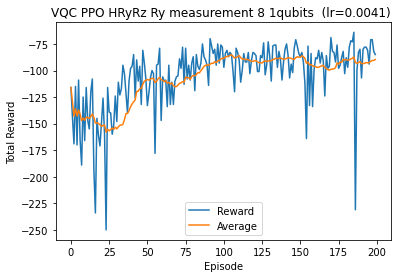

In [5]:

if __name__ == '__main__':
    ITERATIONS = 200
    windows = 20
    env = random.seed(34)

    env = gym.make("Acrobot-v1")
    '''env.observation_space.shape'''
    agent = PPO_agent(env.action_space.n, env.observation_space.shape)
    plot_rewards = []
    avg_reward = deque(maxlen=ITERATIONS)
    best_avg_reward = -math.inf
    rs = deque(maxlen=windows)

    for i in range(ITERATIONS):
        s1 = env.reset()
        episode_reward = 0
        done = False
        while not done:
            # env.render()
            action, p = agent.get_action(s1)
            s2, reward, done, info = env.step(action)
            episode_reward += reward
            agent.remember(s1, reward, action, p)
            s1 = s2
        agent.train()
        plot_rewards.append(episode_reward)
        rs.append(episode_reward)
        avg = np.mean(rs)
        avg_reward.append(avg)
        if i >= windows:
            if avg > best_avg_reward:
                best_avg_reward = avg

        print("\rEpisode {}/{} || Best average reward {}, Current Average {}, Current Iteration Reward {}".format(i,
                                                                                                                  ITERATIONS,
                                                                                                                  best_avg_reward,
                                                                                                                  avg,
                                                                                                                  episode_reward),
              )

    np.save("VQC PPO HRyRz Ry measurement 8 1qubits  (lr=0.0041) rewards", np.asarray(plot_rewards))

    plt.title("VQC PPO HRyRz Ry measurement 8 1qubits  (lr=0.0041) ")
    plt.plot(plot_rewards, label='Reward')
    plt.plot(avg_reward, label='Average')
    plt.legend()
    plt.ylabel('Total Reward')
    plt.xlabel('Episode')
    plt.show()